In [0]:
import tensorflow as tf
from tensorflow import keras

In [2]:
#!pip install wandb
!wandb login

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: 2
wandb: You chose 'Use an existing W&B account'
wandb: You can find your API key in your browser here: https://app.wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: e6edd4756bb09940d6b5d55c06417a69afdd95f9
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


In [0]:
import wandb

In [4]:
wandb.init(project = "One-Shot-Fashion-MNIST")

W&B Run: https://app.wandb.ai/hemansunny1052/One-Shot-Fashion-MNIST/runs/rrk577s5

In [5]:
from keras.models import Sequential,Model
from keras.layers import Dense,Concatenate,Dot,Lambda,Input,Flatten


Using TensorFlow backend.


In [0]:
fashion_mnist = keras.datasets.fashion_mnist

In [8]:
(train_images,train_labels),(test_images,test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [0]:
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')


In [0]:
train_images/=255
test_images/=255

In [0]:
import numpy as np
def make_pairs(x,y):
  num_classes = max(y)+1
  label = [np.where(y==i)[0] for i in range(num_classes)]
  pairs = []
  labels=[]
  
  for id1 in range(len(x)):
    # Same Images
    x1 = x[id1]
    l1  = y[id1]
    id2 = np.random.choice(label[l1])
    x2 = x[id2]
    pairs +=[[x1,x2]]
    labels+=[1]
    
    #Different Images
    l2 = np.random.randint(0,num_classes-1)
    while l2==l1:
      l2 = np.random.randint(0,num_classes-1)
    id2 = np.random.choice(label[l2])
    x2 = x[id2]
    pairs+=[[x1,x2]]
    labels+=[0]
  
  return np.array(pairs),np.array(labels)  

In [0]:
pair_train,pair_labels = make_pairs(train_images,train_labels)

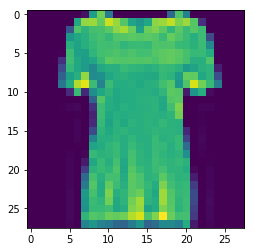

In [13]:
import matplotlib.pyplot as plt
plt.imshow(pair_train[21][0])

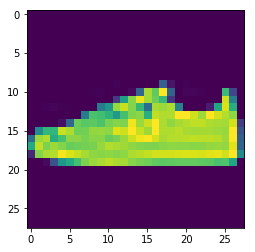

In [14]:
plt.imshow(pair_train[21][1])

In [15]:
pair_labels[21]

0

In [0]:
from keras import backend as K

In [0]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


In [18]:
input = Input((28,28))
x = Flatten()(input)
x = Dense(128,activation='relu')(x)
dense= Model(input,x)
input1 = Input((28,28))
input2 = Input((28,28))

dense1 = dense(input1)
dense2 = dense(input2)

In [19]:
merge_layer = Lambda(euclidean_distance)([dense1,dense2])
dense_layer = Dense(1,activation='sigmoid')(merge_layer)

model = Model(inputs=[input1,input2],output = dense_layer)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  after removing the cwd from sys.path.


In [20]:
model.compile(loss = "binary_crossentropy",optimizer= "adam",metrics=["accuracy"])
model.summary()



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28)       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 28, 28)       0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 128)          100480      input_2[0][0]                    
                                                                 input_3[0][0]                    
_______________________________________________________________________________________________

In [21]:
from wandb.keras import WandbCallback
model.fit([pair_train[:,0],pair_train[:,1]],pair_labels[:],epochs=10,batch_size=16,callbacks=[WandbCallback()])




Epoch 1/10





120000/120000 [==============================] - 43s 361us/step - loss: 0.4360 - acc: 0.8020
Epoch 2/10
120000/120000 [==============================] - 39s 325us/step - loss: 0.3723 - acc: 0.8370
Epoch 3/10
120000/120000 [==============================] - 39s 324us/step - loss: 0.3642 - acc: 0.8400
Epoch 4/10
120000/120000 [==============================] - 39s 328us/step - loss: 0.3538 - acc: 0.8473
Epoch 5/10
120000/120000 [==============================] - 39s 322us/step - loss: 0.3512 - acc: 0.8490
Epoch 6/10
120000/120000 [==============================] - 39s 324us/step - loss: 0.3494 - acc: 0.8499
Epoch 7/10
120000/120000 [==============================] - 39s 326us/step - loss: 0.3479 - acc: 0.8510
Epoch 8/10
120000/120000 [==============================] - 39s 324us/step - loss: 0.3471 - acc: 0.8508
Epoch 9/10
120000/120000 [==============================] - 39s 323us/step - loss: 0.3458 - acc: 0.8520
Epoch 10/10
120000/120000 [=============================

In [22]:
pair_test,pair_test_labels = make_pairs(test_images,test_labels)
model.evaluate([pair_test[:,0],pair_test[:,1]],pair_test_labels)

20000/20000 [==============================] - 1s 68us/step


[0.36632546718120573, 0.84425]